In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import heterograph
import dgl.function as fn
import dgl.utils as dgl_utils
from functools import partial
from dgl.nn.pytorch import RelGraphConv


import numpy as np
import pygraphviz as pgv
import pandas as pd

from sklearn.model_selection import train_test_split
import networkx as nx

from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import time
import utils
from base import BaseRGCN

from sklearn.preprocessing import OneHotEncoder

from prune import prune_graph
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score

import json

from predict import predict_drug

Load graph as a dictionary

### Build Model

In [85]:
class EmbeddingLayer(nn.Module):
    def __init__(self, num_nodes, h_dim):
        super(EmbeddingLayer, self).__init__()
        # create an embedding value [0,1] for each node of the graph
        self.embedding = torch.nn.Embedding(num_nodes, h_dim)

    def forward(self, g, h, r, norm):
        return self.embedding(h.squeeze())

class RGCN(BaseRGCN):
    def build_input_layer(self):
        return EmbeddingLayer(self.num_nodes, self.h_dim)

    def build_hidden_layer(self, idx):
        # build a number of hidden layer according to the parameter
        # add a relu activation function except for the last layer
        act = F.relu if idx < self.num_hidden_layers - 1 else None
        return RelGraphConv(self.h_dim, self.h_dim, self.num_rels, 'basis',
                self.num_bases, activation=act, self_loop=True,
                dropout=self.dropout)

class LinkPredict(nn.Module):
    def __init__(self, in_dim, h_dim, num_rels, num_bases=-1,
                 num_hidden_layers=1, dropout=0, use_cuda=False, reg_param=0):
        """
        Arguments:
        - in_dim (int) -- input feature size
        - h_dim  (int) -- output feature size
        - num_rels (int) -- # relations
        - num_bases (int) -- # bases
        - num_hidden_layers (int) -- # hidden layers
        - dropout (float) -- [0,1] dropout rate
        - use_cuda (bool)
        - reg_param (float) -- regularization parameter
        """
        super(LinkPredict, self).__init__()
        # build RGCN layer
        # 2 x num_rels as both directions are considered
        self.rgcn = RGCN(in_dim, h_dim, h_dim, num_rels * 2, num_bases,
                         num_hidden_layers, dropout, use_cuda)
        # define regularization
        self.reg_param = reg_param
        # define relations and normalize them
        self.w_relation = nn.Parameter(torch.Tensor(num_rels, h_dim))
        nn.init.xavier_uniform_(self.w_relation,
                                gain=nn.init.calculate_gain('relu'))

    def calc_score(self, embedding, triplets):
        # apply DistMult for scoring
        # embedding contains the embedding values of the node after the 
        #   propagation within the RGCN Block layer
        # triplets contains all triples resulting from the negative sampling process
        s = embedding[triplets[:,0]]
        r = self.w_relation[triplets[:,1]]
        o = embedding[triplets[:,2]]
        score = torch.sum(s * r * o, dim=1)
        return score

    def forward(self, g, h, r, norm):
        return self.rgcn.forward(g, h, r, norm)

    def regularization_loss(self, embedding):
        return torch.mean(embedding.pow(2)) + torch.mean(self.w_relation.pow(2))

    def get_loss(self, g, embed, triplets, labels):
        # triplets is a list of data samples (positive and negative)
        # each row in the triplets is a 3-tuple of (source, relation, destination)
        
        # The score is computed with the value-by-value multiplication of
        #   the embedding values of data produced by the negative sampling process
        #   and sum them using the vertical dimension
        
        score = self.calc_score(embed, triplets)
        predict_loss = F.binary_cross_entropy_with_logits(score, labels)
        reg_loss = self.regularization_loss(embed)
        return predict_loss + self.reg_param * reg_loss

def node_norm_to_edge_norm(g, node_norm):
    g = g.local_var()
    # convert to edge norm
    g.ndata['norm'] = node_norm
    g.apply_edges(lambda edges : {'norm' : edges.dst['norm']})
    return g.edata['norm']

### Load the graph

In [86]:
graph = np.load('../data/clean/graph.wse.npy')
pruned = prune_graph(graph, disease_degree_thresh=0,
                drug_degree_thresh=0,
                gene_degree_thresh=200,
                covid_neighbor_hops=0)

Initial # edges: 1159831
Pruning given degree threshold of 0 (disease), 0 (drug), and 200 (gene)...
Given 0 hops, 455 neighboring nodes are obtained.
Removing 16760 nodes...
Adding COVID-19 node: 37893
The final graph contains:
- 318016 edges
- 11048 nodes: 4976 diseases, 1863 genes, 4210 drugs
- 291 covid-19-associated genes (out of 312)
- 57 covid-19 associated genes + drug targets (out of 62)
- 136 covid-19-associated drugs (out of 162)


In [87]:
num_nodes = len(list(set(np.unique(graph[:,0])).union(set(np.unique(graph[:,2]))))) + 1 # add covid nodes
num_rels = np.unique(pruned[:,1]).shape[0]
num_edges = pruned.shape[0]

In [88]:
train_val, test_data = train_test_split(pruned, test_size=0.1, random_state=0)
train_data, val_data = train_test_split(train_val, test_size=0.1, random_state=0)

train_treat = train_data[train_data[:,1] == 0]
train_others = train_data[train_data[:,1] != 0]

val_treat = torch.LongTensor(val_data[val_data[:,1] == 0])
test_treat = torch.LongTensor(test_data[test_data[:,1] == 0])



In [89]:
compute_class_weight(class_weight='balanced',classes=np.unique(train_data[:,1]), y=train_data[:,1])

array([ 3.13475229, 46.5135428 ,  6.83267905,  4.16451644, 32.96966594,
        0.18480823,  0.94491031,  0.23800095,  3.3941023 , 13.02746169,
        8.01244207, 16.59528411,  0.98497635])

### Only focus on drug-disease edge for validation

In [90]:
test_graph, test_rel, test_norm = utils.build_test_graph(
        num_nodes, num_rels, pruned)

Test graph:
# nodes: 37894, # edges: 636032


In [91]:
test_deg = test_graph.in_degrees(
                range(test_graph.number_of_nodes())).float().view(-1, 1)
test_node_id = torch.arange(0, num_nodes, dtype=torch.long).view(-1, 1)
test_rel = torch.from_numpy(test_rel)
test_norm = node_norm_to_edge_norm(test_graph, torch.from_numpy(test_norm).view(-1, 1))

In [92]:
# model params
model_param = {
    'in_dim'   : num_nodes,
    'h_dim'    : 100, # output feature size
    'num_rels' : num_rels,
    'dropout'  : 0.2,
    'use_cuda' : True,
    'reg_param': 0.01
}
use_cuda = model_param['use_cuda']
torch.cuda.set_device(0)

In [93]:
# create the model
model = LinkPredict(in_dim   = model_param['in_dim'],
                    h_dim    = model_param['h_dim'],
                    num_rels = model_param['num_rels'],
                    dropout  = model_param['dropout'],
                    use_cuda = model_param['use_cuda'],
                    reg_param= model_param['reg_param'])
if use_cuda:
    model.cuda()

In [94]:
# build adj list and calculate degrees for sampling
adj_list, degrees = utils.get_adj_and_degrees(num_nodes, train_data)

In [95]:
# optimizer
optimizer = torch.optim.Adam(model.parameters())

In [101]:
epoch = 0
epoch_mult_eval = 100 # multiplication of n epochs to indicate when to evaluate
best_mrr = 0
best_acc = 0
forward_time = []
backward_time = []
eval_batch = 1000
model_state_file = 'model_state_haoxin.pth'

In [97]:
sample_graph_param = {
    'sample_size'  : 10000, # edges to sample
    'split_size'   : 0.5,
    'negative_rate': 1,
}

In [98]:
adj_list, degrees = utils.get_adj_and_degrees(num_nodes, val_treat.numpy())
g, node_id, edge_type, node_norm, data, labels = \
    utils.generate_weighted_graph_and_labels(
        val_treat.numpy(), 
        val_treat.shape[0],
        0.5,
        num_rels, 
        adj_list,
        degrees,
        1,
        sampler='uniform')

print("Finished edge sampling")

# set node/edge feature
test_node_id = torch.from_numpy(node_id).view(-1, 1).long()
edge_type = torch.from_numpy(edge_type)
edge_norm = node_norm_to_edge_norm(g, torch.from_numpy(node_norm).view(-1, 1))
data, labels = torch.from_numpy(data), torch.from_numpy(labels)
deg = g.in_degrees(range(g.number_of_nodes())).float().view(-1, 1)
if use_cuda:
    val_node_id, val_deg = node_id.cuda(), deg.cuda()
    val_edge_type, val_edge_norm = edge_type.cuda(), edge_norm.cuda()
    val_data = data.cuda()


# sampled nodes: 791
# sampled edges: 686
# nodes: 791, # edges: 686
Finished edge sampling


AttributeError: 'numpy.ndarray' object has no attribute 'cuda'

In [99]:
val_embed = model(g, val_node_id.cuda(), val_edge_type.cuda(), val_edge_norm.cuda())
pred= (torch.sigmoid(model.calc_score(val_embed, data)).cpu().detach().numpy()) > 0.5  

In [100]:
roc_auc_score(labels,pred)

0.5254730713245997

In [102]:
train_loss = []
print("start training...")
while epoch < 5001:
    model.train()
    epoch += 1

    # Perform edge neighborhood sampling to generate training graph and data
    # The training stage is performed on a sample graph (not the entire graph)
    g, node_id, edge_type, node_norm, data, labels = \
        utils.generate_weighted_graph_and_labels(
            train_data, 
            sample_graph_param['sample_size'],
            sample_graph_param['split_size'],
            num_rels, 
            adj_list,
            degrees,
            sample_graph_param['negative_rate'],
            train_treat,
            train_others,
            sampler='treat')
    
    print("Finished edge sampling")
    
    # set node/edge feature
    node_id = torch.from_numpy(node_id).view(-1, 1).long()
    edge_type = torch.from_numpy(edge_type)
    edge_norm = node_norm_to_edge_norm(g, torch.from_numpy(node_norm).view(-1, 1))
    data, labels = torch.from_numpy(data), torch.from_numpy(labels)
    deg = g.in_degrees(range(g.number_of_nodes())).float().view(-1, 1)
    if use_cuda:
        node_id, deg = node_id.cuda(), deg.cuda()
        edge_type, edge_norm = edge_type.cuda(), edge_norm.cuda()
        data, labels = data.cuda(), labels.cuda()

    t0 = time.time()
    embed = model(g, node_id, edge_type, edge_norm)
    loss = model.get_loss(g, embed, data, labels)
    train_loss.append(loss)
    t1 = time.time()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients
    optimizer.step()
    t2 = time.time()

    forward_time.append(t1 - t0)
    backward_time.append(t2 - t1)
    print("Epoch {:04d} | Loss {:.4f} | Best MRR {:.4f} | Forward {:.4f}s | Backward {:.4f}s".
              format(epoch, loss.item(), best_mrr, forward_time[-1], backward_time[-1]))

    optimizer.zero_grad()

    # validation
    if epoch % epoch_mult_eval == 0:
        print('Run evaluation...')
        # perform validation on CPU because full graph is too large
        if use_cuda: 
#             model.cpu()
            model.eval()
#             embed = model(test_graph, test_node_id.cuda(), test_rel.cuda(), test_norm.cuda())
#             mrr = utils.calc_mrr(embed, model.w_relation, torch.LongTensor(train_val_data),
#                                  val_data, test_data, hits=[1, 3, 10], eval_bz=eval_batch,
#                                  eval_p='filtered')
            pred = (torch.sigmoid(model.calc_score(embed, data)) > 0.5).cpu()
            acc = accuracy_score(labels.cpu(),pred)
            print('The accuracy is {}. \n'.format(acc))
        # save best model
#         if mrr > best_mrr:
#             best_mrr = mrr
#             best_mrr = mrr
#             torch.save({'state_dict': model.state_dict(), 'epoch': epoch},
#                        model_state_file)
        if use_cuda:
            model.cuda()

        

start training...
# sampled nodes: 4806
# sampled edges: 10000
# nodes: 4806, # edges: 10000
Finished edge sampling
Epoch 0001 | Loss 1.9879 | Best MRR 0.0000 | Forward 0.0105s | Backward 0.0322s
# sampled nodes: 4803
# sampled edges: 10000
# nodes: 4803, # edges: 10000
Finished edge sampling
Epoch 0002 | Loss 1.8911 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0127s
# sampled nodes: 4790
# sampled edges: 10000
# nodes: 4790, # edges: 10000
Finished edge sampling
Epoch 0003 | Loss 1.8821 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0127s
# sampled nodes: 4815
# sampled edges: 10000
# nodes: 4815, # edges: 10000
Finished edge sampling
Epoch 0004 | Loss 1.8170 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0126s
# sampled nodes: 4788
# sampled edges: 10000
# nodes: 4788, # edges: 10000
Finished edge sampling


/home/haoxin/Harvard/mlhc/COVID19-Drug-Repurposing/model/utils.py:173: RuntimeWarning: divide by zero encountered in true_divide
  norm = 1.0 / in_deg


Epoch 0005 | Loss 1.8275 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0126s
# sampled nodes: 4807
# sampled edges: 10000
# nodes: 4807, # edges: 10000
Finished edge sampling
Epoch 0006 | Loss 1.7800 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0125s
# sampled nodes: 4798
# sampled edges: 10000
# nodes: 4798, # edges: 10000
Finished edge sampling
Epoch 0007 | Loss 1.7645 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0126s
# sampled nodes: 4796
# sampled edges: 10000
# nodes: 4796, # edges: 10000
Finished edge sampling
Epoch 0008 | Loss 1.7442 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0123s
# sampled nodes: 4805
# sampled edges: 10000
# nodes: 4805, # edges: 10000
Finished edge sampling
Epoch 0009 | Loss 1.6992 | Best MRR 0.0000 | Forward 0.0029s | Backward 0.0122s
# sampled nodes: 4790
# sampled edges: 10000
# nodes: 4790, # edges: 10000
Finished edge sampling
Epoch 0010 | Loss 1.6781 | Best MRR 0.0000 | Forward 0.0028s | Backward 0.0123s
# sampled nodes: 4795
# sample

KeyboardInterrupt: 

In [104]:
            torch.save({'state_dict': model.state_dict(), 'epoch': epoch},
                       model_state_file)

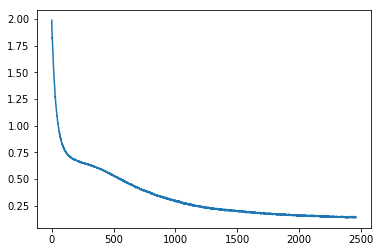

In [103]:
plt.plot(train_loss)

### make covid triplets

Test graph:
# nodes: 37894, # edges: 636032


/home/haoxin/Harvard/mlhc/COVID19-Drug-Repurposing/model/utils.py:173: RuntimeWarning: divide by zero encountered in true_divide
  norm = 1.0 / in_deg


In [60]:
covid_triplets = []
for i in range(8079):
    covid_triplets.append([i,0, 37893])
covid_triplets = np.array(covid_triplets)

In [63]:
graph_covid, rel_covid, norm_covid = utils.build_test_graph(
        num_nodes, num_rels, covid_triplets)

Test graph:
# nodes: 37894, # edges: 16158


In [80]:
rel_covid.shape

(16158,)

In [72]:
embed_pruned = model(graph_covid, test_node_id.cuda(), rel_covid, norm_covid)

DGLError: Expect number of features to match number of edges. Got 37894 and 16158 instead.

In [181]:
predict_drug(pruned, model, embed, covid19_num = 37893, topk=100)

intersection of drug_topk and covid_drugs: ['DB14761', 'DB15623', 'DB14724', 'DB14999', 'DB14545']


['DB15665',
 'DB15647',
 'DB15643',
 'DB15624',
 'DB15623',
 'DB15617',
 'DB15599',
 'DB15598',
 'DB15593',
 'DB15580',
 'DB15575',
 'DB15570',
 'DB15569',
 'DB15568',
 'DB15566',
 'DB15565',
 'DB15534',
 'DB15498',
 'DB15496',
 'DB15495',
 'DB15494',
 'DB15493',
 'DB15489',
 'DB15488',
 'DB15463',
 'DB15444',
 'DB15328',
 'DB15323',
 'DB15293',
 'DB15271',
 'DB15250',
 'DB15233',
 'DB15212',
 'DB15131',
 'DB15119',
 'DB15091',
 'DB15035',
 'DB14999',
 'DB14975',
 'DB14962',
 'DB14879',
 'DB14864',
 'DB14811',
 'DB14783',
 'DB14762',
 'DB14761',
 'DB14754',
 'DB14751',
 'DB14738',
 'DB14733',
 'DB14732',
 'DB14731',
 'DB14724',
 'DB14723',
 'DB14707',
 'DB14700',
 'DB14681',
 'DB14679',
 'DB14678',
 'DB14669',
 'DB14659',
 'DB14656',
 'DB14655',
 'DB14652',
 'DB14649',
 'DB14646',
 'DB14644',
 'DB14642',
 'DB14641',
 'DB14640',
 'DB14639',
 'DB14638',
 'DB14637',
 'DB14635',
 'DB14634',
 'DB14633',
 'DB14631',
 'DB14627',
 'DB14600',
 'DB14598',
 'DB14597',
 'DB14596',
 'DB14583',
 'DB

In [ ]:
covid_node=37893

In [176]:
pd.read_csv('../data/clean/drugs.nodes').shape

(8093, 1)

### Prediction

In [172]:
json.load(open('../data/clean/covid-drug-num-dict.wse.json'))

{'DB00003': 2,
 'DB00009': 8,
 'DB00020': 19,
 'DB00026': 24,
 'DB00028': 26,
 'DB00060': 56,
 'DB00068': 62,
 'DB00112': 101,
 'DB00126': 114,
 'DB00146': 134,
 'DB00151': 139,
 'DB00158': 146,
 'DB00159': 147,
 'DB00177': 164,
 'DB00178': 165,
 'DB00198': 185,
 'DB00203': 190,
 'DB00207': 194,
 'DB00254': 240,
 'DB00275': 260,
 'DB00279': 264,
 'DB00302': 287,
 'DB00328': 313,
 'DB00338': 322,
 'DB00339': 323,
 'DB00343': 327,
 'DB00381': 365,
 'DB00393': 376,
 'DB00396': 379,
 'DB00435': 418,
 'DB00436': 419,
 'DB00440': 423,
 'DB00457': 440,
 'DB00477': 460,
 'DB00480': 463,
 'DB00492': 475,
 'DB00503': 486,
 'DB00507': 489,
 'DB00519': 499,
 'DB00524': 504,
 'DB00542': 522,
 'DB00545': 525,
 'DB00563': 543,
 'DB00584': 564,
 'DB00602': 581,
 'DB00608': 587,
 'DB00619': 598,
 'DB00633': 612,
 'DB00635': 614,
 'DB00641': 620,
 'DB00661': 639,
 'DB00678': 653,
 'DB00704': 679,
 'DB00722': 697,
 'DB00736': 710,
 'DB00741': 715,
 'DB00746': 720,
 'DB00758': 732,
 'DB00766': 740,
 'DB00